In [1]:
import os
import cv2
import glob
import shutil

import pandas as pd
import pathlib
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from PIL import Image as ImagePIL

from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential

# Custom Funcs
from Unpack_Scaffold_Data import readAndOutputDataset, curveVisualization

2023-06-15 00:21:59.345759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Read Utility

In [2]:
curve_path = "/Users/zacharyg/Documents/GitHub/fundemental-neural-nets/GANS/Scaffold_GAN/scaffold_dataset_WU_LAB/Prints"
modulus_path = "/Users/zacharyg/Documents/GitHub/fundemental-neural-nets/GANS/Scaffold_GAN/scaffold_dataset_WU_LAB/Prints/modulus_data_types.csv"


In [3]:
X, y, y_df, file_order = readAndOutputDataset(curve_path, modulus_path, reverse=True);

DOC COUNT: 675
Operation Finished.

     Index     Modulus  Spacing  Infill  Height  Speed  Temperature   Mass  \
0        1  358.528888      0.8       1     0.1     30          190  0.394   
1        2  301.639039      0.9       1     0.1     30          190  0.334   
2        3  292.501492      1.0       1     0.1     30          190  0.308   
3        4  258.539802      1.1       1     0.1     30          190  0.286   
4        5  238.213024      1.2       1     0.1     30          190  0.259   
..     ...         ...      ...     ...     ...    ...          ...    ...   
670    671  151.559731      0.8       3     0.2     50          230  0.428   
671    672   85.074096      0.9       3     0.2     50          230  0.341   
672    673   52.285252      1.0       3     0.2     50          230  0.290   
673    674   70.811230      1.1       3     0.2     50          230  0.292   
674    675   36.627466      1.2       3     0.2     50          230  0.244   

     Porosity    Type  
0  

In [4]:
# Sanity Check
print("X SHAPE:", X.shape);
print("y SHAPE:", y.shape);
print();

# Visualization
# curveVisualization(X, y, file_order);

X SHAPE: (675, 2, 1803)
y SHAPE: (675, 10)



# Utility

In [5]:
def transposeStressData(X_Data):
    X = [];
    
    for data in X_Data:
        X.append(data.T);
        
    return np.array(X);

def normalizeStressStrain(x):
    for curve_index in range(len(x)):
        curve = x[curve_index];
        
        max_stress_val = np.max(curve[0]);
        max_strain_val = np.max(curve[1]);
        
        curve[0] = curve[0] / max_stress_val;
        curve[1] = curve[1] / max_strain_val;
        
    return x;

def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    
    Parameters
    -----------------
    x: Array of Homogenous (RGB) values of input data 
    
    Returns
    -----------------
    new_imgs: (numpy integer array) Numpy array of normalized data
    """
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))

def stringtoCategorical(y):    
    data = [];
    
    for type_index in range(len(y)):
        wrd = y[type_index];
        encoding = 0.0;
        
        if (wrd == "Cubic"):
            encoding = 1.0;
        elif (wrd == "Gyroid"):
            encoding = 2.0;
            
        data.append([encoding]);
        
    return np.array(data);

# 3D Processing Parameter Stripping

In [6]:
def parameterStrip(y):
    y_t = y.T;
    
    Index = y_t[0];
    Modulus = y_t[1];
    Spacing = y_t[2];
    Infill = y_t[3];
    Height = y_t[4];
    Speed = y_t[5];
    Temp = y_t[6];
    Mass = y_t[7];
    Porosity = y_t[8];
    Type = y_t[9];
    return Index, Modulus, Spacing, Infill, Height, Speed, Temp, Mass, Porosity, Type

Index, Modulus, Spacing, Infill, Height, Speed, Temp, Mass, Porosity, Type = parameterStrip(y);


# Stress-Strain preprocessing

In [7]:
# Normalize the X data
X_norm = normalizeStressStrain(X);


# LSTM -> Dense (Sequential Classification)

In [14]:
X_norm_T = transposeStressData(X_norm); # This is for LSTM, needs to be (sample, timesteps, features);
print(X_norm_T.shape);

y = Porosity.astype('float32')

(675, 1803, 2)


## Split

In [26]:
# X_train, X_test, y_train, y_test = train_test_split(X_norm_T, y, test_size=0.33, random_state=42);
X_train, X_test, y_train, y_test = train_test_split(X_norm_T, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# One hot encoding
# y_train = tf.keras.utils.to_categorical(y_train);
# y_test = tf.keras.utils.to_categorical(y_test);
# y_val = tf.keras.utils.to_categorical(y_val);

print(y_train);

print(y_test[0]);

# Sanity Check:
print("X_Train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print();
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print();
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

[0.7488 0.3328 0.7328 0.608  0.7688 0.7736 0.724  0.312  0.4232 0.8
 0.2552 0.372  0.808  0.7616 0.7184 0.672  0.7616 0.1296 0.3456 0.664
 0.7496 0.764  0.4672 0.7048 0.7616 0.3992 0.756  0.6808 0.7376 0.4384
 0.4376 0.6712 0.68   0.324  0.74   0.7792 0.6712 0.772  0.7728 0.6768
 0.7728 0.4104 0.3112 0.5544 0.3152 0.3464 0.8144 0.7688 0.7456 0.6856
 0.2728 0.7728 0.3648 0.1112 0.7472 0.4864 0.1144 0.7976 0.2584 0.2768
 0.7952 0.7656 0.3416 0.8208 0.7968 0.6944 0.7952 0.8088 0.6608 0.7472
 0.2952 0.6808 0.7664 0.364  0.7928 0.7704 0.296  0.2264 0.74   0.468
 0.7336 0.8304 0.7944 0.7552 0.2056 0.8016 0.2488 0.7824 0.7952 0.2816
 0.1592 0.8    0.7704 0.6952 0.7592 0.7744 0.2328 0.2512 0.3776 0.5704
 0.8056 0.6776 0.7944 0.6872 0.7624 0.8312 0.2    0.8264 0.76   0.8024
 0.7264 0.2776 0.3496 0.256  0.244  0.6768 0.72   0.7328 0.4696 0.7896
 0.788  0.752  0.7312 0.7536 0.2    0.7632 0.3672 0.7512 0.7824 0.1216
 0.772  0.7976 0.7928 0.112  0.7888 0.7848 0.3136 0.7544 0.7392 0.7592
 0.7832 0.7

## LSTM Model

In [31]:
def LSTM():
    model = Sequential();
    model.add(tf.keras.layers.LSTM(2, input_shape=(1803, 2), return_sequences=True));
    model.add(tf.keras.layers.LSTM(2, input_shape=(1803, 2), return_sequences=True));
    model.add(tf.keras.layers.LSTM(2, input_shape=(1803, 2), return_sequences=True));
    model.add(tf.keras.layers.LSTM(2, input_shape=(1803, 2), return_sequences=False));
    model.add(tf.keras.layers.Dense(1, activation="tanh"));
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), 
        optimizer=opt, 
    );
    
    return model;

# Training

In [32]:
LSTM_Model = LSTM();
LSTM_Model.summary();


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1803, 2)           40        
                                                                 
 lstm_7 (LSTM)               (None, 1803, 2)           40        
                                                                 
 lstm_8 (LSTM)               (None, 1803, 2)           40        
                                                                 
 lstm_9 (LSTM)               (None, 2)                 40        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 163
Trainable params: 163
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = LSTM_Model.fit(
    X_train, 
    y_train, 
    epochs=2, 
    batch_size=100,
    validation_data=(X_val, y_val)
);

Epoch 1/2
 34/405 [=>............................] - ETA: 5:38 - loss: 0.1029

KeyboardInterrupt: 

# Graphs

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


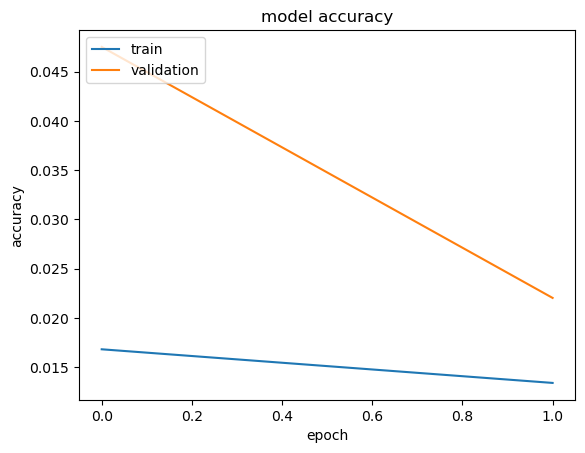

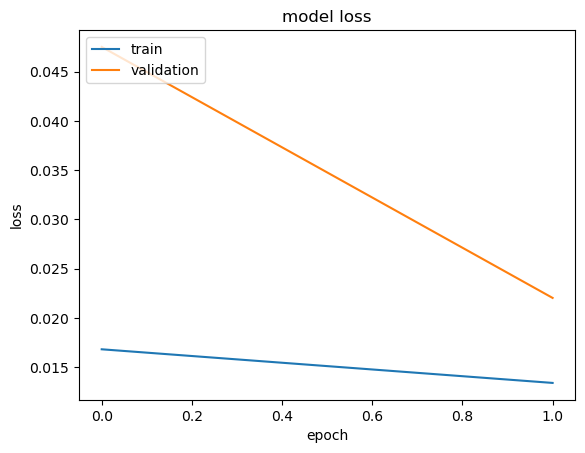

In [25]:
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [30]:
print(LSTM_Model.predict(X_test));
print(y_test);

5/5 [==============================] - 0s 95ms/step
[[0.7019543 ]
 [0.70193106]
 [0.24186082]
 [0.70632863]
 [0.70194244]
 [0.7019401 ]
 [0.70196706]
 [0.70195335]
 [0.7019619 ]
 [0.70194244]
 [0.703348  ]
 [0.701936  ]
 [0.70633656]
 [0.7058643 ]
 [0.70194   ]
 [0.702966  ]
 [0.7033859 ]
 [0.70195746]
 [0.7019491 ]
 [0.70195264]
 [0.70195246]
 [0.24186079]
 [0.7045542 ]
 [0.7019603 ]
 [0.7019505 ]
 [0.7061507 ]
 [0.7019519 ]
 [0.70194775]
 [0.7019615 ]
 [0.7019596 ]
 [0.7033504 ]
 [0.24186082]
 [0.7019564 ]
 [0.7027041 ]
 [0.7019503 ]
 [0.701957  ]
 [0.701954  ]
 [0.7019532 ]
 [0.70195   ]
 [0.24186082]
 [0.7019631 ]
 [0.70195335]
 [0.7051748 ]
 [0.701943  ]
 [0.24211106]
 [0.7059088 ]
 [0.70006794]
 [0.70194876]
 [0.70195425]
 [0.70195395]
 [0.70195246]
 [0.7019491 ]
 [0.7051229 ]
 [0.7019632 ]
 [0.70052224]
 [0.24592613]
 [0.70312613]
 [0.6959045 ]
 [0.24186082]
 [0.7019779 ]
 [0.7019521 ]
 [0.7019339 ]
 [0.7019482 ]
 [0.7019598 ]
 [0.7019539 ]
 [0.70193976]
 [0.7019457 ]
 [0.701946

# Save Model

In [ ]:
# MAKE SURE TO MODIFY MODEL NAME AND FOLLOW THE NAMING FORMAT!
# Naming Format: feature_LSTM

model_name = "Type_LSTM"
save_path = "/Users/zacharyg/Documents/GitHub/fundemental-neural-nets/GANS/Scaffold_GAN/" + model_name
if not os.path.exists(save_path):
    os.makedirs(save_path);
    
LSTM_Model.save(save_path);